In [1]:
import json
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import statsmodels
import csv
import pickle

# Processing Data from PostGRES Output

Creating a single JSON file for each participant from PostGRES data that contains a single list of all participant data

In [2]:
fileprefix = "pilot_3" # pilot_[1,2,4]
filepath = '../results/{}_results.json'.format(fileprefix)


In [3]:
with open(filepath, 'r') as f:
    all_data = json.load(f)

In [4]:
part_data = {}

count = 0
for participant in all_data['values']:
    count+=1
    print(count, participant[2])
    try:
        part_object = json.loads(participant[17])
        part_object["Beginhit"] = participant[11]
        part_object["Beginexp"] = participant[12]
        part_object["Endhit"] = participant[13]
        part_object["psiturkStatus"] = participant[15]
        part_object["browser"] = participant[5]
        part_object["platform"] = participant[6]
        part_object["language"] = participant[7]
        
        if part_object["workerId"].startswith("debug"):
            continue

        part_data[part_object["workerId"]] = part_object
        with open('../results/{}_{}.json'.format(fileprefix, part_object['workerId']), 'w') as fw:
            json.dump(part_object, fw)
    except:
        print("Fail")
        continue;

1 6129429473f164c90c476660
2 5f23c8b2be6a4e1a1481ba56
3 6079da01106b8305f11b4fc6
4 60fd3f08f3f4fc43bc33676d
5 60553b36cb4eb3269931ed21
6 debugKdcvV
7 5efb5159147ea4089af8685d
8 5b7af290db11320001c3ff1d
9 60f74d629edc41b4de32bc69
10 61686f7c1353e4177cdbb792
11 61241440b58a4621e8c2f050
12 5d2b153afa24ba00173e8ee0
13 603cd0286ba69eabb56845e8
14 6156d957727841ad2f3378d8
15 616ad68130d71e76d1ef148e
16 6176a69fc678f3095b6f8cd2
17 60a57eaea2033e5e99734feb
18 5dfd14b6ac9e16a152ff0794
19 60f6f2d84993d38ff83bbf17
20 60feee53991033aa986fa755
21 5e6493cba2235c20d4d5238d
22 5ebab0103b481401100eadd9
23 5d248359c34532001ae8d43a
24 61641b8573a9dcd29ba9d87b
25 5c5dae957557640001f501fc
26 60968cdf142e93f2a5ff070a
27 615d680edf6513f5c858b28d
28 5f340f702739302a1d1822be
29 611cf4b38923b75da77562bf
30 60f1d99a67bc1538a6dadc94
31 61127b4ee0fc6aac8d202a6d
32 61563a4b0def9000ccc976ec


In [5]:
part_data.keys()


dict_keys(['6129429473f164c90c476660', '5f23c8b2be6a4e1a1481ba56', '6079da01106b8305f11b4fc6', '60fd3f08f3f4fc43bc33676d', '60553b36cb4eb3269931ed21', '5efb5159147ea4089af8685d', '5b7af290db11320001c3ff1d', '60f74d629edc41b4de32bc69', '61686f7c1353e4177cdbb792', '61241440b58a4621e8c2f050', '5d2b153afa24ba00173e8ee0', '603cd0286ba69eabb56845e8', '6156d957727841ad2f3378d8', '616ad68130d71e76d1ef148e', '6176a69fc678f3095b6f8cd2', '60a57eaea2033e5e99734feb', '5dfd14b6ac9e16a152ff0794', '60f6f2d84993d38ff83bbf17', '60feee53991033aa986fa755', '5e6493cba2235c20d4d5238d', '5ebab0103b481401100eadd9', '5d248359c34532001ae8d43a', '61641b8573a9dcd29ba9d87b', '5c5dae957557640001f501fc', '60968cdf142e93f2a5ff070a', '615d680edf6513f5c858b28d', '5f340f702739302a1d1822be', '611cf4b38923b75da77562bf', '60f1d99a67bc1538a6dadc94', '61127b4ee0fc6aac8d202a6d', '61563a4b0def9000ccc976ec'])

# Reading Data from Already Created Participant Data Files

In [3]:
fileprefix = "pilot_3" # pilot_#, final
datafolder = '../results/'

all_part_files = [filename for filename in os.listdir(datafolder) if filename.startswith(fileprefix) and 'results' not in filename]
all_part_paths = [datafolder + filename for filename in all_part_files]

In [4]:
part_data = {}
for file in all_part_paths:
    with open(file, 'r') as f:
        participant = json.load(f)
        part_data[participant["workerId"]] = participant



In [5]:
len(part_data.keys())

74

# Analyzing Trial Data

Create a list of objects, one for each participant's data

In [6]:
part_stats_dicts = []
for participant in part_data.values():
    try:
        beginhit = datetime.datetime.strptime(participant['Beginhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginhit = None
    try:
        endhit = datetime.datetime.strptime(participant['Endhit'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        endhit = None
    try:    
        beginexp = datetime.datetime.strptime(participant['Beginexp'], '%Y-%m-%d %H:%M:%S.%f')
    except TypeError:
        beginexp = None
    
    try:
        hitLength = (endhit-beginhit).seconds
    except TypeError:
        hitLength = None
    
    try:
        expLength = (endhit-beginexp).seconds
    except TypeError:
        expLength = None
        
    numPracTrials = 0
    trialLengths = []
    trialScores = []
    rewardsWithheld = []
    effort = "-1"
    age = None
    gender = None
    colorblind = None
    print(participant['workerId'])
    try:
        firstTrialStamp = participant['data'][0]['dateTime']
        lastTrialStamp = participant['data'][-1]['dateTime']
    except:
        print("No data")
        continue
    if hitLength is None:
        hitLength = (lastTrialStamp - firstTrialStamp) / 1000
    if expLength is None:
        expLength = (lastTrialStamp - firstTrialStamp) / 1000
        
    mdp_timestamps = {
        "start" : 0,
        "end" : 0,
        "done": False
    }
    current_state = "stroop_1"
    last_trial = participant['data'][0]
    finishHITReached = False
    demographicsAvailable = False
    feedback = ""
    alreadyParticipated = ""
    comments = ""
    whatStrategy = ""
    clicksL1 = []
    firstLevelAns = {}
    strategyImprove = ""
    difficult = ""
    num_correct_sequences = 0
    final_quiz_responses = None
    for idx, trial in enumerate(participant['data']):
        trial_type = trial['trialdata']['trial_type']
        try:
            trial_id = str(trial['trialdata']['trial_id'])
        except KeyError:
            trial_id = ""
        
        if participant['workerId'] == "5eb40f1f0d916d20d9db9144":
            print("{}\t{}\t{}".format(trial_type, trial_id, idx))
            
        if trial_id.startswith("mouselab_instructions_1") and not mdp_timestamps["done"]:
            mdp_timestamps["done"] = True
            mdp_timestamps["start"] = trial['dateTime']
        
        if "num_correct_sequences" in trial['trialdata']:
            num_correct_sequences = trial['trialdata']['num_correct_sequences']
        
        if trial_id.startswith("final_quiz"):
            mdp_timestamps["end"] = trial['dateTime']
            final_quiz_responses = trial['trialdata']['response']

        if trial_id.startswith("self_report_2"):
            firstLevelAns = trial['trialdata']['response']
        
        if trial_id.startswith("finish_fail"):
            feedback = trial['trialdata']['response']['Q0']
            age = trial['trialdata']['response']['Q1']
            gender = trial['trialdata']['response']['Q2']
            colorblind = trial['trialdata']['response']['Q3']
            comments = trial['trialdata']['response']['Q4']
            demographicsAvailable = True
            
        if trial_type == 'mouselab-mdp':
            if trial_id.startswith('practice'):
                numPracTrials += 1
            else:
                trialLengths.append(trial['trialdata']['trialTime'])
                
                trialScores.append(trial['trialdata']['score'])
                rewardsWithheld.append(trial['trialdata']['withholdReward'])
                clicks = trial['trialdata']['queries']['click']['state']['target']
                cL1 = len([c for c in clicks if int(c) in [1,12,23]])
                clicksL1.append(cL1)
        if trial_type == 'survey-html-form':
            
            if 'effort' in trial['trialdata']['response']:
                effort = trial['trialdata']['response']['effort']
                age = trial['trialdata']['response']['age']
                gender = trial['trialdata']['response']['gender']
                colorblind = trial['trialdata']['response']['colorblind']
                demographicsAvailable = True
        
        elif trial_type == 'survey-text':
            if trial_id.startswith("self_report"):
                whatStrategy = trial['trialdata']['response']['Q0']
                strategyImprove = trial['trialdata']['response']['Q1']
                difficult = trial['trialdata']['response']['Q2']
            
            elif not trial_id.startswith("answer"):
                #print(trial['trialdata'])
                feedback = trial['trialdata']['response']['Q0']
                alreadyParticipated = trial['trialdata']['response']['Q1']
                comments = trial['trialdata']['response']['Q2']
        
        if trial_type == 'html-button-response':
            if "Finish HIT" in trial['trialdata']['stimulus']:
                finishHITReached = True
        last_trial = trial

    dropoutPoint = None
    for obj, type_ in zip([mdp_timestamps], ["mdp"]):
        if obj["start"] > 0 and obj["end"] == 0:
            
            dropoutPoint = type_
            obj["end"] = lastTrialStamp
            
    if not dropoutPoint:
        if len(trialLengths) == 0:
            dropoutPoint = "beginning"
        elif not finishHITReached:
            dropoutPoint = "finishHIT"
            
    if dropoutPoint:
        print(participant['workerId'], dropoutPoint)
    part_stats_dict = {
        "workerId": participant['workerId'],
        "Beginhit": beginhit,
        "Endhit": endhit,
        "Beginexp": beginexp,
        "psiturkStatus" : participant["psiturkStatus"],
        "browser" : participant["browser"],
        "platform" : participant["platform"],
        "language" : participant["language"],
        "hitLength": hitLength,
        "expLength": expLength,
        "totalLengthSum": (lastTrialStamp - firstTrialStamp) / 1000,
        "numQuizAttempts": numPracTrials / 2,
        "trialLengths": trialLengths,
        "trialScores" : trialScores,
        "numTrialsCompleted": len(trialLengths),
        "rewardsWithheld": rewardsWithheld,
        "effort": effort,
        "clicksL1": clicksL1,
        "age":age,
        "colorblind":colorblind,
        "gender":gender,
        "condition": participant['condition'],
        "mouselabLength" : (mdp_timestamps["end"] - mdp_timestamps["start"]) / 1000,
        "dropoutPoint" : dropoutPoint,
        "feedback": feedback,
        "alreadyParticipated": alreadyParticipated,
        "comments": comments,
        "finishHITReached": finishHITReached,
        "demographicsAvailable": demographicsAvailable,
        "whatStrategy": whatStrategy,
        "strategyImprove": strategyImprove,
        "difficult": difficult,
        "firstLevelAns": firstLevelAns,
        "num_correct_sequences": num_correct_sequences,
        "final_quiz_responses": final_quiz_responses
    }
    if 'questiondata' in participant and 'final_score' in participant['questiondata']:
        part_stats_dict['finalScore'] = participant['questiondata']['final_score']
    else:
        part_stats_dict['finalScore'] = sum([score for (score, withheld) in zip(trialScores, rewardsWithheld) if not withheld])
    
    part_stats_dict["expLengthSum"] = part_stats_dict["mouselabLength"]
    part_stats_dict["expLengthDiff"] = part_stats_dict["expLengthSum"] - part_stats_dict["expLength"]
    if len(trialLengths) > 0:
        part_stats_dict["averageTrialLength"] = sum(trialLengths) / len(trialLengths)
        part_stats_dict["propWithheld"] = sum(rewardsWithheld) / len(rewardsWithheld)
        
    part_stats_dicts.append(part_stats_dict)
    

6160ccb0810a73f90ef4c5e7
61066e991d3b7cc1eacf2a53
61066e991d3b7cc1eacf2a53 mdp
6310b43bd9f974e46765836b
6116422e3fd768e0eb82fa98
5ed3b2b3397ebb01e2c64923
5ed3b2b3397ebb01e2c64923 mdp
5e0d4d2d7605fe4d7fba6f5e
612296b87416dfaf670907cd
5c0fdebfdfbb180001c32177
No data
59c93d675e01580001977815
59c93d675e01580001977815 mdp
601c1a00178c02637f1659a1
601c1a00178c02637f1659a1 mdp
60dec770e794837d68214ae1
5fc9ec3d0990d4501dfd7e05
6120b4fca2fedeb88787374c
610b743b3f893111e9fa3986
610b743b3f893111e9fa3986 mdp
5fa061eeb1f28d08b4e40501
60e6e91bf2974c65f8296342
60dfcb70b6cede357105e6ed
5c4f4ce19eeaf00001598126
616c4409a2bcfe1fdb942117
60d77edd5ede206b58b8b9c8
5d616bd447787f000175cd9e
60daf06339acaaccef1a00932
60daf06339acaaccef1a00932 mdp
5fdfd04b9bf07d83b2e5f780
5ea98f445ef6ee093f4f05ec
60f2be10f84eb35558463468
61570d5eb2963a6d6ea3719a
61570d5eb2963a6d6ea3719a mdp
60475f804d6ac923410a4b12
5e083e0a35a7a5178670e03e
616eb493bb7e4ab4fa1de8d4
611e1cb0e8882a2a1e9f456d
60d101464180f5f5cd211e77
5efbe7a1cae4

In [7]:
stats_df = pd.DataFrame(part_stats_dicts)
print(len(stats_df))
filter_cols = ["workerId", "Beginhit", "hitLength", "expLength", "condition", "numQuizAttempts", "numTrialsCompleted", "mouselabLength", "finalScore", "num_correct_sequences", "dropoutPoint", "finishHITReached", "psiturkStatus", "effort", "demographicsAvailable"]
stats_df[filter_cols]

73


,workerId,Beginhit,hitLength,expLength,condition,numQuizAttempts,numTrialsCompleted,mouselabLength,finalScore,num_correct_sequences,dropoutPoint,finishHITReached,psiturkStatus,effort,demographicsAvailable
0,6160ccb0810a73f90ef4c5e7,2023-07-10 13:59:20.070738,2660.000,2645.000,0,1.0,40,1826.164,2224.20,0,None,True,3,0,True
1,61066e991d3b7cc1eacf2a53,2023-07-10 13:57:49.569212,1066.172,1066.172,1,1.0,30,833.582,-105.35,0,mdp,False,6,-1,False
2,6310b43bd9f974e46765836b,2023-07-10 14:00:09.201824,4252.000,4242.000,1,1.0,40,3779.878,1797.85,0,None,True,3,0,True
3,6116422e3fd768e0eb82fa98,2023-07-10 14:03:53.062483,2589.000,2332.000,1,1.0,40,1799.648,2123.60,0,None,True,3,1,True
4,5ed3b2b3397ebb01e2c64923,2023-07-10 13:59:13.534306,686.770,686.770,0,3.0,0,529.216,0.00,0,mdp,False,6,-1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,5ff6d9ee8c6cb429d55ea0fa,2023-07-10 13:57:26.485826,1814.000,1807.000,0,1.0,40,1239.673,213.20,0,None,True,3,0,True
69,613e4bf960ca68f8de00e5e7,2023-07-10 14:31:10.475116,1687.000,1676.000,0,1.0,40,1297.736,2243.80,0,None,True,3,0,True
70,60957c141c93ecc64fe6b4ea,2023-07-10 13:55:28.522361,3409.000,3391.000,1,1.0,40,2950.954,1946.70,0,None,True,3,0,True
71,6070c2f8aa9a08d466b86d5c,2023-07-10 13:58:39.906441,261.209,261.209,0,2.0,0,149.868,0.00,0,mdp,False,6,-1,False


In [8]:
# Filter those who dropped out immediately

immediate_drops = stats_df.loc[(stats_df.dropoutPoint == "beginning")]
print(len(immediate_drops))
immediate_drops

1


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,strategyImprove,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
32,60e2fbb1eec0ddbbe525aa49,2023-07-10 15:03:31.812540,NaT,2023-07-10 15:03:47.521009,2,chrome,windows,en-AU,42.325,42.325,...,,,{},0,None,0.0,0.0,-42.325,NaN,NaN


In [9]:
no_immediate_drops = stats_df.loc[(stats_df.dropoutPoint != "beginning")]
print(len(no_immediate_drops))
no_immediate_drops

72


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,strategyImprove,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,6160ccb0810a73f90ef4c5e7,2023-07-10 13:59:20.070738,2023-07-10 14:43:40.481753,2023-07-10 13:59:34.806782,3,chrome,windows,en-ZA,2660.000,2645.000,...,Yes. I learned possible ways to reduce lose an...,It was easy to learn from my experience along ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",2224.20,1826.164,-818.836,37418.775000,0.0
1,61066e991d3b7cc1eacf2a53,2023-07-10 13:57:49.569212,NaT,2023-07-10 13:57:57.048557,6,safari,macos,de-DE,1066.172,1066.172,...,,,{},0,None,-105.35,833.582,-232.590,23250.433333,0.0
2,6310b43bd9f974e46765836b,2023-07-10 14:00:09.201824,2023-07-10 15:11:02.134611,2023-07-10 14:00:19.332677,3,chrome,windows,ru-RU,4252.000,4242.000,...,Yes. I stopped clicking on the closest nodes a...,I figured it about half way through. So 50/50 ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1797.85,3779.878,-462.122,89182.700000,0.0
3,6116422e3fd768e0eb82fa98,2023-07-10 14:03:53.062483,2023-07-10 14:47:02.625006,2023-07-10 14:08:09.999236,3,chrome,windows,pt-PT,2589.000,2332.000,...,"Yes, initially just saw the end nodes. Then st...",I think in the begining is hard to understand ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",2123.60,1799.648,-532.352,39792.375000,0.0
4,5ed3b2b3397ebb01e2c64923,2023-07-10 13:59:13.534306,NaT,2023-07-10 13:59:24.971077,6,firefox,linux,pt-PT,686.770,686.770,...,,,{},0,None,0.00,529.216,-157.554,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,5ff6d9ee8c6cb429d55ea0fa,2023-07-10 13:57:26.485826,2023-07-10 14:27:40.544392,2023-07-10 13:57:32.625518,3,chrome,windows,en-GB,1814.000,1807.000,...,Not really,It was quite difficult as the nodes had differ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",213.20,1239.673,-567.327,27170.225000,0.0
69,613e4bf960ca68f8de00e5e7,2023-07-10 14:31:10.475116,2023-07-10 14:59:18.451120,2023-07-10 14:31:22.162182,3,chrome,windows,en-US,1687.000,1676.000,...,"Yes, at first I looked at the closest nodes an...","It wasn't hard, I just needed to get lucky and...",{},0,"{'Q0': '$-16 to 16', 'Q1': '$-32 to $32', 'Q2'...",2243.80,1297.736,-378.264,28295.075000,0.0
70,60957c141c93ecc64fe6b4ea,2023-07-10 13:55:28.522361,2023-07-10 14:52:17.600739,2023-07-10 13:55:46.382025,3,chrome,windows,en-GB,3409.000,3391.000,...,"I don't think so, I just spent money on nodes","It wasn't too bad, if you don't mind losing a ...",{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",1946.70,2950.954,-440.046,64326.350000,0.0
71,6070c2f8aa9a08d466b86d5c,2023-07-10 13:58:39.906441,NaT,2023-07-10 13:58:47.280750,6,opera,windows,pl-PL,261.209,261.209,...,,,{},0,None,0.00,149.868,-111.341,NaN,NaN


In [10]:
# Partial compensation rates

gbp_hourly = 6.00
secondly_rate = gbp_hourly / (3600)

In [11]:
# Early quitters - Psiturk status 6 or 2, and no quiz attempts completed

early_quitters = no_immediate_drops.loc[(no_immediate_drops.psiturkStatus == 6) & (no_immediate_drops.numQuizAttempts == 0)]
early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate
print(len(early_quitters))

# Printing bonuses
for idx, row in early_quitters.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
    
early_quitters

2
59c93d675e01580001977815, 0.78 0
60daf06339acaaccef1a00932, 0.01 0


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_31859/3936591574.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  early_quitters.loc[:,'bonus'] = (early_quitters['expLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
7,59c93d675e01580001977815,2023-07-10 13:57:49.904289,NaT,2023-07-10 13:58:02.046527,6,chrome,linux,en-US,470.261,470.261,...,,{},0,None,0.0,0.0,-470.261,NaN,NaN,0.783768
20,60daf06339acaaccef1a00932,2023-07-10 13:46:14.431519,NaT,2023-07-10 13:46:17.651489,6,chrome,macos,en-US,6.912,6.912,...,,{},0,None,0.0,0.0,-6.912,NaN,NaN,0.011520


In [12]:
# Filtering those who failed the quiz more than 4 times

failed_quiz = no_immediate_drops.loc[(no_immediate_drops.numQuizAttempts > 0) & (no_immediate_drops.numTrialsCompleted == 0)]
failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate
print(len(failed_quiz))

# Printing bonuses
for idx, row in failed_quiz.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))
failed_quiz

11
5ed3b2b3397ebb01e2c64923, 0.88
601c1a00178c02637f1659a1, 0.42
61570d5eb2963a6d6ea3719a, 0.84
61224ccef1ce5b2169df0f44, 1.93
6482f8b93bfd2bc0f245e504, 0.35
5f98383ec3a3c80b6c8190a6, 0.22
6005a70567c8e981ead530b5, 0.30
60f579085ebf24f9c80f223e, 0.24
608690e9fc999a08f141b708, 0.44
616cdeebd38a9ca9cdc4b481, 3.23
6070c2f8aa9a08d466b86d5c, 0.25


/var/folders/8k/zq6x09px4838xflgn88yhgdw0002cw/T/ipykernel_31859/3569009787.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  failed_quiz.loc[:,'bonus'] = (failed_quiz['mouselabLength']) * secondly_rate


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
4,5ed3b2b3397ebb01e2c64923,2023-07-10 13:59:13.534306,NaT,2023-07-10 13:59:24.971077,6,firefox,linux,pt-PT,686.770,686.770,...,,{},0,None,0.0,529.216,-157.554,NaN,NaN,0.882027
8,601c1a00178c02637f1659a1,2023-07-10 13:56:46.197736,NaT,2023-07-10 13:57:12.339207,6,firefox,windows,pt-PT,476.592,476.592,...,,{},0,None,0.0,254.884,-221.708,NaN,NaN,0.424807
24,61570d5eb2963a6d6ea3719a,2023-07-10 14:06:01.090991,NaT,2023-07-10 14:06:23.122755,6,chrome,windows,en-GB,663.856,663.856,...,,{},0,None,0.0,503.011,-160.845,NaN,NaN,0.838352
33,61224ccef1ce5b2169df0f44,2023-07-10 14:06:51.097168,2023-07-10 14:29:53.116911,2023-07-10 14:07:00.843184,3,chrome,windows,en-GB,1382.000,1372.000,...,,{},0,None,0.0,1160.042,-211.958,NaN,NaN,1.933403
36,6482f8b93bfd2bc0f245e504,2023-07-10 13:59:33.634148,NaT,2023-07-10 13:59:40.935270,6,chrome,windows,nl-NL,369.532,369.532,...,,{},0,None,0.0,207.149,-162.383,NaN,NaN,0.345248
44,5f98383ec3a3c80b6c8190a6,2023-07-10 13:55:59.896706,NaT,2023-07-10 13:56:05.341380,6,chrome,windows,pt-PT,162.384,162.384,...,,{},0,None,0.0,131.625,-30.759,NaN,NaN,0.219375
49,6005a70567c8e981ead530b5,2023-07-10 13:58:26.808317,NaT,2023-07-10 13:58:55.914684,6,chrome,windows,pt-PT,399.697,399.697,...,,{},0,None,0.0,178.537,-221.160,NaN,NaN,0.297562
53,60f579085ebf24f9c80f223e,2023-07-10 13:55:19.926413,NaT,2023-07-10 13:55:31.536617,6,chrome,windows,en-US,206.001,206.001,...,,{},0,None,0.0,146.919,-59.082,NaN,NaN,0.244865
55,608690e9fc999a08f141b708,2023-07-10 13:54:53.525711,NaT,2023-07-10 13:55:06.089243,6,chrome,windows,nl-NL,405.002,405.002,...,,{},0,None,0.0,262.501,-142.501,NaN,NaN,0.437502
65,616cdeebd38a9ca9cdc4b481,2023-07-10 13:58:55.243393,2023-07-10 14:37:02.057437,2023-07-10 13:59:13.079129,3,chrome,windows,en-US,2286.000,2268.000,...,,{},0,None,0.0,1940.702,-327.298,NaN,NaN,3.234503


In [13]:
failed_quiz[["workerId","numQuizAttempts", "dropoutPoint", "numTrialsCompleted"]]

,workerId,numQuizAttempts,dropoutPoint,numTrialsCompleted
4,5ed3b2b3397ebb01e2c64923,3.0,mdp,0
8,601c1a00178c02637f1659a1,1.0,mdp,0
24,61570d5eb2963a6d6ea3719a,2.0,mdp,0
33,61224ccef1ce5b2169df0f44,4.0,mdp,0
36,6482f8b93bfd2bc0f245e504,1.0,mdp,0
44,5f98383ec3a3c80b6c8190a6,1.0,mdp,0
49,6005a70567c8e981ead530b5,1.0,mdp,0
53,60f579085ebf24f9c80f223e,1.0,mdp,0
55,608690e9fc999a08f141b708,1.0,mdp,0
65,616cdeebd38a9ca9cdc4b481,4.0,mdp,0


In [14]:
for idx, row in failed_quiz.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

5ed3b2b3397ebb01e2c64923	0
601c1a00178c02637f1659a1	0
61570d5eb2963a6d6ea3719a	0
61224ccef1ce5b2169df0f44	0
6482f8b93bfd2bc0f245e504	0
5f98383ec3a3c80b6c8190a6	0
6005a70567c8e981ead530b5	1
60f579085ebf24f9c80f223e	1
608690e9fc999a08f141b708	1
616cdeebd38a9ca9cdc4b481	0
6070c2f8aa9a08d466b86d5c	0


In [15]:
eligible = no_immediate_drops.loc[(~no_immediate_drops['workerId'].isin(early_quitters.workerId)) & (~no_immediate_drops['workerId'].isin(failed_quiz.workerId))]
print(len(eligible))
eligible

59


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,strategyImprove,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,6160ccb0810a73f90ef4c5e7,2023-07-10 13:59:20.070738,2023-07-10 14:43:40.481753,2023-07-10 13:59:34.806782,3,chrome,windows,en-ZA,2660.000,2645.000,...,Yes. I learned possible ways to reduce lose an...,It was easy to learn from my experience along ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",2224.20,1826.164,-818.836,37418.775000,0.0
1,61066e991d3b7cc1eacf2a53,2023-07-10 13:57:49.569212,NaT,2023-07-10 13:57:57.048557,6,safari,macos,de-DE,1066.172,1066.172,...,,,{},0,None,-105.35,833.582,-232.590,23250.433333,0.0
2,6310b43bd9f974e46765836b,2023-07-10 14:00:09.201824,2023-07-10 15:11:02.134611,2023-07-10 14:00:19.332677,3,chrome,windows,ru-RU,4252.000,4242.000,...,Yes. I stopped clicking on the closest nodes a...,I figured it about half way through. So 50/50 ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1797.85,3779.878,-462.122,89182.700000,0.0
3,6116422e3fd768e0eb82fa98,2023-07-10 14:03:53.062483,2023-07-10 14:47:02.625006,2023-07-10 14:08:09.999236,3,chrome,windows,pt-PT,2589.000,2332.000,...,"Yes, initially just saw the end nodes. Then st...",I think in the begining is hard to understand ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",2123.60,1799.648,-532.352,39792.375000,0.0
5,5e0d4d2d7605fe4d7fba6f5e,2023-07-10 14:18:19.384509,2023-07-10 14:43:26.781634,2023-07-10 14:18:26.282710,3,chrome,windows,pt-PT,1507.000,1500.000,...,"Yes, I started very anxious but once I got the...",Not very difficult.,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",1410.40,1188.170,-311.830,24623.175000,0.0
6,612296b87416dfaf670907cd,2023-07-10 13:59:40.866135,2023-07-10 14:26:43.127563,2023-07-10 13:59:47.085010,3,chrome,windows,pt-PT,1622.000,1616.000,...,"I focused on the last nodes, instead of the fi...",No problem,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",838.00,1453.350,-162.650,24036.625000,0.0
9,60dec770e794837d68214ae1,2023-07-10 13:57:25.367793,2023-07-10 14:43:40.736900,2023-07-10 13:57:31.791579,3,chrome,windows,en-US,2775.000,2768.000,...,"Yes, at first i thought i could only discover ...","Not difficult at all, just needed more practice.",{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1425.80,2198.090,-569.910,49358.625000,0.0
10,5fc9ec3d0990d4501dfd7e05,2023-07-10 14:04:07.997689,2023-07-10 14:52:25.890599,2023-07-10 14:04:19.185334,3,chrome,windows,en-US,2897.000,2886.000,...,I don't think i needed to improve my strategy ...,It was difficult because there was an element ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1633.75,1521.455,-1364.545,28704.500000,0.0
11,6120b4fca2fedeb88787374c,2023-07-10 13:59:27.144597,2023-07-10 14:41:01.465959,2023-07-10 14:00:09.089518,3,chrome,windows,en-US,2494.000,2452.000,...,definitely. I realised the end values matter m...,it wasn't difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1231.60,1802.084,-649.916,36737.825000,0.0
12,610b743b3f893111e9fa3986,2023-07-10 13:57:44.108448,NaT,2023-07-10 13:57:50.763105,6,safari,macos,en-US,1426.413,1426.413,...,,,{},0,None,873.60,1239.172,-187.241,31691.600000,0.0


In [16]:
data_actually_complete = []

In [17]:
incomplete_data = eligible.loc[(eligible.psiturkStatus != 3) & (~eligible.workerId.isin(data_actually_complete))]
print(len(incomplete_data))
incomplete_data[["workerId", "numTrialsCompleted", "dropoutPoint"]]

3


,workerId,numTrialsCompleted,dropoutPoint
1,61066e991d3b7cc1eacf2a53,30,mdp
12,610b743b3f893111e9fa3986,30,mdp
50,60fdcb486e092bc7c1d9c748,0,mdp


In [18]:
for idx, row in incomplete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

61066e991d3b7cc1eacf2a53	1
610b743b3f893111e9fa3986	0
60fdcb486e092bc7c1d9c748	0


In [19]:

incomplete_full_compensation_eligible = ["6156d957727841ad2f3378d8"]
incomplete_partial_compensation_eligible = []


In [20]:
incomplete_partial = eligible.loc[(eligible.workerId.isin(incomplete_partial_compensation_eligible))]
incomplete_partial.loc[:,'bonus'] = (incomplete_partial['mouselabLength']) * secondly_rate
print(len(incomplete_partial))

# Printing bonuses
for idx, row in incomplete_partial.iterrows():
    print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']), row['condition'])
incomplete_partial

0


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus


In [21]:
# Participant data that is complete

complete_data = eligible.loc[(eligible.psiturkStatus == 3) | (eligible.workerId.isin(data_actually_complete))]
print(len(complete_data.loc[complete_data.condition == 0]))
print(len(complete_data.loc[complete_data.condition == 1]))
#print(len(complete_data.loc[complete_data.condition == 2]))
complete_data

25
31


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,strategyImprove,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,6160ccb0810a73f90ef4c5e7,2023-07-10 13:59:20.070738,2023-07-10 14:43:40.481753,2023-07-10 13:59:34.806782,3,chrome,windows,en-ZA,2660.0,2645.0,...,Yes. I learned possible ways to reduce lose an...,It was easy to learn from my experience along ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",2224.20,1826.164,-818.836,37418.775,0.0
2,6310b43bd9f974e46765836b,2023-07-10 14:00:09.201824,2023-07-10 15:11:02.134611,2023-07-10 14:00:19.332677,3,chrome,windows,ru-RU,4252.0,4242.0,...,Yes. I stopped clicking on the closest nodes a...,I figured it about half way through. So 50/50 ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1797.85,3779.878,-462.122,89182.700,0.0
3,6116422e3fd768e0eb82fa98,2023-07-10 14:03:53.062483,2023-07-10 14:47:02.625006,2023-07-10 14:08:09.999236,3,chrome,windows,pt-PT,2589.0,2332.0,...,"Yes, initially just saw the end nodes. Then st...",I think in the begining is hard to understand ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",2123.60,1799.648,-532.352,39792.375,0.0
5,5e0d4d2d7605fe4d7fba6f5e,2023-07-10 14:18:19.384509,2023-07-10 14:43:26.781634,2023-07-10 14:18:26.282710,3,chrome,windows,pt-PT,1507.0,1500.0,...,"Yes, I started very anxious but once I got the...",Not very difficult.,{},0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",1410.40,1188.170,-311.830,24623.175,0.0
6,612296b87416dfaf670907cd,2023-07-10 13:59:40.866135,2023-07-10 14:26:43.127563,2023-07-10 13:59:47.085010,3,chrome,windows,pt-PT,1622.0,1616.0,...,"I focused on the last nodes, instead of the fi...",No problem,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",838.00,1453.350,-162.650,24036.625,0.0
9,60dec770e794837d68214ae1,2023-07-10 13:57:25.367793,2023-07-10 14:43:40.736900,2023-07-10 13:57:31.791579,3,chrome,windows,en-US,2775.0,2768.0,...,"Yes, at first i thought i could only discover ...","Not difficult at all, just needed more practice.",{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1425.80,2198.090,-569.910,49358.625,0.0
10,5fc9ec3d0990d4501dfd7e05,2023-07-10 14:04:07.997689,2023-07-10 14:52:25.890599,2023-07-10 14:04:19.185334,3,chrome,windows,en-US,2897.0,2886.0,...,I don't think i needed to improve my strategy ...,It was difficult because there was an element ...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1633.75,1521.455,-1364.545,28704.500,0.0
11,6120b4fca2fedeb88787374c,2023-07-10 13:59:27.144597,2023-07-10 14:41:01.465959,2023-07-10 14:00:09.089518,3,chrome,windows,en-US,2494.0,2452.0,...,definitely. I realised the end values matter m...,it wasn't difficult.,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",1231.60,1802.084,-649.916,36737.825,0.0
13,5fa061eeb1f28d08b4e40501,2023-07-10 13:55:35.997419,2023-07-10 14:35:24.843791,2023-07-10 13:55:42.905955,3,opera,windows,pl-PL,2388.0,2381.0,...,"After understanding the algorythm, I proceeded...",The only difficult part is remembering and kno...,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",2468.20,1634.571,-746.429,34259.750,0.0
14,60e6e91bf2974c65f8296342,2023-07-10 13:53:27.446888,2023-07-10 14:25:10.560233,2023-07-10 13:53:35.575714,3,opera,windows,es-ES,1903.0,1894.0,...,I perfectioned my strategy every round until I...,Not that much. It's just trial and error,{},0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",2175.25,1521.049,-372.951,32061.175,0.0


In [126]:
for idx, row in complete_data.iterrows():
    print("{}\t{}".format(row['workerId'], row['condition']))

6129429473f164c90c476660	0
5f23c8b2be6a4e1a1481ba56	0
6079da01106b8305f11b4fc6	0
60fd3f08f3f4fc43bc33676d	0
60553b36cb4eb3269931ed21	0
5efb5159147ea4089af8685d	0
5b7af290db11320001c3ff1d	0
61686f7c1353e4177cdbb792	0
61241440b58a4621e8c2f050	0
5d2b153afa24ba00173e8ee0	0
603cd0286ba69eabb56845e8	0
616ad68130d71e76d1ef148e	0
6176a69fc678f3095b6f8cd2	0
60a57eaea2033e5e99734feb	0
5dfd14b6ac9e16a152ff0794	0
60f6f2d84993d38ff83bbf17	0
60feee53991033aa986fa755	0
5e6493cba2235c20d4d5238d	0
5ebab0103b481401100eadd9	0
5d248359c34532001ae8d43a	0
61641b8573a9dcd29ba9d87b	0
5c5dae957557640001f501fc	0
60968cdf142e93f2a5ff070a	0
615d680edf6513f5c858b28d	0
5f340f702739302a1d1822be	0
611cf4b38923b75da77562bf	0
60f1d99a67bc1538a6dadc94	0
61127b4ee0fc6aac8d202a6d	0
61563a4b0def9000ccc976ec	0


In [127]:
# Participants eligible for full bonus

full_bonus_eligible = pd.concat([complete_data, eligible.loc[eligible.workerId.isin(incomplete_full_compensation_eligible)]])

print(len(full_bonus_eligible))
full_bonus_eligible

30


,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,strategyImprove,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld
0,6129429473f164c90c476660,2023-07-20 14:45:42.186918,2023-07-20 15:06:47.221658,2023-07-20 14:45:49.466841,3,chrome,windows,es-ES,1265.000,1257.000,...,I do not think I improved it,"It is pretty difficult, since you have to own ...","{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",697.55,796.796,-460.204,23006.88,0.0
1,5f23c8b2be6a4e1a1481ba56,2023-07-20 14:17:49.782927,2023-07-20 14:36:24.794724,2023-07-20 14:18:00.257676,3,chrome,windows,en-NZ,1115.000,1104.000,...,I feel that I was getting more green positive ...,"I think it improved, I don't think it was diff...","{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",-3.85,625.457,-478.543,18182.88,0.0
2,6079da01106b8305f11b4fc6,2023-07-20 14:12:53.688995,2023-07-20 14:50:33.628274,2023-07-20 14:13:03.128295,3,chrome,windows,pl-PL,2259.000,2250.000,...,The strategy was the same.,Sometimes i couldn't find positive values and ...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",1246.25,1079.581,-1170.419,27074.48,0.0
3,60fd3f08f3f4fc43bc33676d,2023-07-20 14:17:43.815857,2023-07-20 14:47:35.507095,2023-07-20 14:17:51.430829,3,chrome,windows,pt-PT,1791.000,1784.000,...,"instead of following one path till the end, I ...",spending money on inspecting nodes,"{'Q0': 'Strongly agree', 'Q1': 'Strongly disag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",1096.60,1196.086,-587.914,37941.24,0.0
4,60553b36cb4eb3269931ed21,2023-07-20 15:34:17.572914,2023-07-20 15:56:25.069427,2023-07-20 15:34:23.511455,3,chrome,windows,en-US,1327.000,1321.000,...,"I tried not to spend a lot, went for the most ...",In my opinion the amounts were randomized.,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",1497.15,766.975,-554.025,23600.76,0.0
5,5efb5159147ea4089af8685d,2023-07-20 14:05:33.018796,2023-07-20 14:25:19.635932,2023-07-20 14:05:39.074556,3,chrome,windows,pt-PT,1186.000,1180.000,...,The first round I started investigating the fi...,I didn't find it difficult.,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Stron...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",1336.25,706.747,-473.253,20879.64,0.0
6,5b7af290db11320001c3ff1d,2023-07-20 14:05:15.433999,2023-07-20 14:24:18.354327,2023-07-20 14:05:21.543835,3,chrome,windows,pt-PT,1142.000,1136.000,...,"Yes, first I didn't expect so many nodes and w...",The balance between spending money to inspect ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",826.35,753.469,-382.531,21869.44,0.0
8,61686f7c1353e4177cdbb792,2023-07-20 14:05:49.555570,2023-07-20 14:38:26.798894,2023-07-20 14:06:01.653884,3,chrome,windows,en-US,1957.000,1945.000,...,no,I could not figure out the pattern,"{'Q0': 'Strongly agree', 'Q1': 'Neither disagr...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",-222.00,1055.685,-889.315,25018.92,0.0
9,61241440b58a4621e8c2f050,2023-07-20 14:05:51.073527,2023-07-20 14:29:08.288327,2023-07-20 14:06:03.876905,3,chrome,windows,en-GB,1397.000,1384.000,...,"Yes, I did. Initially I was just guessing my w...",Slightly. I think time constraints made it dif...,"{'Q0': 'Strongly disagree', 'Q1': 'Agree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",265.45,932.364,-451.636,20542.56,0.0
10,5d2b153afa24ba00173e8ee0,2023-07-20 14:06:07.182514,2023-07-20 14:24:52.217308,2023-07-20 14:06:21.884395,3,chrome,windows,pl-PL,1125.000,1110.000,...,No,"Difficult, couldn't figure it out","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",-27.15,641.292,

In [128]:
#full_bonus_eligible.loc[full_bonus_eligible.workerId == "5f6214a59413141f7cb2508c"]

In [129]:
# Calculating the bonus conversion rate for each condition

max_bonus = 1.5

fix_bonus_rate = True
fixed_bonus_rate = 0.000833


bonus_calc_cols = ["condition", "finalScore"]

bonus_rate = {}

for condition in np.unique(full_bonus_eligible.condition):
    if not fix_bonus_rate:
        bonus_rate[condition] = max_bonus / full_bonus_eligible.loc[full_bonus_eligible.condition == condition].finalScore.max()
    else:
        bonus_rate[condition] = fixed_bonus_rate

# stats_df_filtered = stats_df.loc[stats_df['numTrialsCompleted'] > 0]

bonuses = []
# Adding the bonus for each participant
for idx, row in full_bonus_eligible.iterrows():
    bonuses.append(bonus_rate[row['condition']] * row['finalScore'])

full_bonus_eligible['bonus'] = bonuses
full_bonus_eligible

,workerId,Beginhit,Endhit,Beginexp,psiturkStatus,browser,platform,language,hitLength,expLength,...,difficult,firstLevelAns,num_correct_sequences,final_quiz_responses,finalScore,expLengthSum,expLengthDiff,averageTrialLength,propWithheld,bonus
0,6129429473f164c90c476660,2023-07-20 14:45:42.186918,2023-07-20 15:06:47.221658,2023-07-20 14:45:49.466841,3,chrome,windows,es-ES,1265.000,1257.000,...,"It is pretty difficult, since you have to own ...","{'Q0': 'Agree', 'Q1': 'Strongly disagree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",697.55,796.796,-460.204,23006.88,0.0,0.581059
1,5f23c8b2be6a4e1a1481ba56,2023-07-20 14:17:49.782927,2023-07-20 14:36:24.794724,2023-07-20 14:18:00.257676,3,chrome,windows,en-NZ,1115.000,1104.000,...,"I think it improved, I don't think it was diff...","{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Agree...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",-3.85,625.457,-478.543,18182.88,0.0,-0.003207
2,6079da01106b8305f11b4fc6,2023-07-20 14:12:53.688995,2023-07-20 14:50:33.628274,2023-07-20 14:13:03.128295,3,chrome,windows,pl-PL,2259.000,2250.000,...,Sometimes i couldn't find positive values and ...,"{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",1246.25,1079.581,-1170.419,27074.48,0.0,1.038126
3,60fd3f08f3f4fc43bc33676d,2023-07-20 14:17:43.815857,2023-07-20 14:47:35.507095,2023-07-20 14:17:51.430829,3,chrome,windows,pt-PT,1791.000,1784.000,...,spending money on inspecting nodes,"{'Q0': 'Strongly agree', 'Q1': 'Strongly disag...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",1096.60,1196.086,-587.914,37941.24,0.0,0.913468
4,60553b36cb4eb3269931ed21,2023-07-20 15:34:17.572914,2023-07-20 15:56:25.069427,2023-07-20 15:34:23.511455,3,chrome,windows,en-US,1327.000,1321.000,...,In my opinion the amounts were randomized.,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Disag...",0,"{'Q0': '$-88 to $88', 'Q1': '$-16 to $16', 'Q2...",1497.15,766.975,-554.025,23600.76,0.0,1.247126
5,5efb5159147ea4089af8685d,2023-07-20 14:05:33.018796,2023-07-20 14:25:19.635932,2023-07-20 14:05:39.074556,3,chrome,windows,pt-PT,1186.000,1180.000,...,I didn't find it difficult.,"{'Q0': 'Agree', 'Q1': 'Disagree', 'Q2': 'Stron...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",1336.25,706.747,-473.253,20879.64,0.0,1.113096
6,5b7af290db11320001c3ff1d,2023-07-20 14:05:15.433999,2023-07-20 14:24:18.354327,2023-07-20 14:05:21.543835,3,chrome,windows,pt-PT,1142.000,1136.000,...,The balance between spending money to inspect ...,"{'Q0': 'Disagree', 'Q1': 'Disagree', 'Q2': 'Di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-32 to $32', 'Q2':...",826.35,753.469,-382.531,21869.44,0.0,0.688350
8,61686f7c1353e4177cdbb792,2023-07-20 14:05:49.555570,2023-07-20 14:38:26.798894,2023-07-20 14:06:01.653884,3,chrome,windows,en-US,1957.000,1945.000,...,I could not figure out the pattern,"{'Q0': 'Strongly agree', 'Q1': 'Neither disagr...",0,"{'Q0': '$-16 to 16', 'Q1': '$-16 to $16', 'Q2'...",-222.00,1055.685,-889.315,25018.92,0.0,-0.184926
9,61241440b58a4621e8c2f050,2023-07-20 14:05:51.073527,2023-07-20 14:29:08.288327,2023-07-20 14:06:03.876905,3,chrome,windows,en-GB,1397.000,1384.000,...,Slightly. I think time constraints made it dif...,"{'Q0': 'Strongly disagree', 'Q1': 'Agree', 'Q2...",0,"{'Q0': '$-2 to $2', 'Q1': '$-4 to $4', 'Q2': '...",265.45,932.364,-451.636,20542.56,0.0,0.221120
10,5d2b153afa24ba00173e8ee0,2023-07-20 14:06:07.182514,2023-07-20 14:24:52.217308,2023-07-20 14:06:21.884395,3,chrome,windows,pl-PL,1125.000,1110.000,...,"Difficult, couldn't figure it out","{'Q0': 'Strongly disagree', 'Q1': 'Strongly di...",0,"{'Q0': '$-2 to $2', 'Q1': '$-16 to $16', 'Q2':...",-27.15,641.292,-468.708,17282.32,0.0,-0.022616


In [130]:
full_bonus_eligible.loc[full_bonus_eligible.condition == 2]["num_correct_sequences"]

Series([], Name: num_correct_sequences, dtype: int64)

In [131]:
# Bonus rates

bonus_rate

{0: 0.000833}

In [132]:
# Printing bonuses

for idx, row in full_bonus_eligible.iterrows():
    if(row['bonus'] > 0):
        print('{0}, {1:0.2f}'.format(row['workerId'], row['bonus']))

6129429473f164c90c476660, 0.58
6079da01106b8305f11b4fc6, 1.04
60fd3f08f3f4fc43bc33676d, 0.91
60553b36cb4eb3269931ed21, 1.25
5efb5159147ea4089af8685d, 1.11
5b7af290db11320001c3ff1d, 0.69
61241440b58a4621e8c2f050, 0.22
603cd0286ba69eabb56845e8, 1.11
616ad68130d71e76d1ef148e, 0.79
6176a69fc678f3095b6f8cd2, 0.29
60a57eaea2033e5e99734feb, 0.89
5dfd14b6ac9e16a152ff0794, 0.94
60f6f2d84993d38ff83bbf17, 0.13
60feee53991033aa986fa755, 1.03
5e6493cba2235c20d4d5238d, 1.13
5ebab0103b481401100eadd9, 1.22
5d248359c34532001ae8d43a, 0.76
61641b8573a9dcd29ba9d87b, 0.40
5c5dae957557640001f501fc, 0.59
60968cdf142e93f2a5ff070a, 0.31
615d680edf6513f5c858b28d, 1.04
5f340f702739302a1d1822be, 0.90
611cf4b38923b75da77562bf, 0.35
61127b4ee0fc6aac8d202a6d, 0.82
61563a4b0def9000ccc976ec, 0.07
6156d957727841ad2f3378d8, 0.37


In [133]:
# Average bonus

print(full_bonus_eligible["bonus"].mean())
print(full_bonus_eligible["bonus"].std())

0.6187287983333334
0.43977017685026537


In [134]:
# Time taken per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].expLength
    print("Mean: " + str(clength.mean()/60))
    print("Std: " + str(clength.std()/60))
    print("Median: " + str(clength.median()/60))


Condition: 0
Mean: 25.822988505747126
Std: 7.319364962090349
Median: 23.983333333333334

Condition: 1
Mean: nan
Std: nan
Median: nan

Condition: 2
Mean: nan
Std: nan
Median: nan


In [28]:
# Final score per condition

for condition in [0,1,2]:
    print("\nCondition: " +str(condition))
    clength = complete_data.loc[complete_data.condition == condition].finalScore
    print("Mean: " + str(clength.mean()))
    print("Std: " + str(clength.std()))
    print("Median: " + str(clength.median()))


Condition: 0
Mean: 742.7716666666668
Std: 527.9353863748685
Median: 869.175

Condition: 1
Mean: nan
Std: nan
Median: nan

Condition: 2
Mean: nan
Std: nan
Median: nan


# Creating CSV for MCL Toolbox

Converting participant data into a CSV format that is appropriate for reading by mcl_toolbox models

In [22]:
s = "pid,trial_index,action_time,actions,block,path,queries,reward,rt,condition,bonus,score,simulation_mode,state_rewards,time_elapsed,trialTime,trial_type"

for h in s.split(","):
    print("\"{}\",".format(h))

"pid",
"trial_index",
"action_time",
"actions",
"block",
"path",
"queries",
"reward",
"rt",
"condition",
"bonus",
"score",
"simulation_mode",
"state_rewards",
"time_elapsed",
"trialTime",
"trial_type",


In [23]:
header_row = [
    "pid",
    "trial_index",
    "action_time",
    "actions",
    "block",
    "path",
    "queries",
    "reward",
    "rt",
    "condition",
    "bonus",
    "score",
    "simulation_mode",
    "state_rewards",
    "time_elapsed",
    "trialTime",
    "trial_type",
    "reward_withheld"
]


In [24]:
scarce_complete = complete_data[complete_data.condition == 1]
control_complete = complete_data[complete_data.condition == 0]


control_csv_rows = [header_row]
scarce_csv_rows = [header_row]

# Create a CSV table with all the trials as rows
for workerId in complete_data.workerId:
    # Read data as was present in PostGRES output
    # Part_data object created at very beginning of this notebook
    participant = part_data[workerId]
    trial_count = 1
    click_cost = participant["condition"] * 0.25 + (1 - participant["condition"])
    for idx, data_point in enumerate(participant["data"]):
        trialdata = data_point["trialdata"]
        if trialdata["trial_type"] == "mouselab-mdp" and trialdata["trial_id"].startswith("mdp_"):
            num_clicks = len(trialdata["queries"]["click"]["state"]["target"])
            new_row = [
                workerId,
                trial_count,
                trialdata["actionTimes"],
                trialdata["actions"],
                "begin" if trial_count <= 10 else "test",
                trialdata["path"],
                trialdata["queries"],
                trialdata["rewards"],
                trialdata["rt"],
                participant["condition"],
                0,
                trialdata["score"],
                [None] * 3,
                trialdata["stateRewards"],
                trialdata["time_elapsed"],
                trialdata["trialTime"],
                trialdata["trial_type"],
                trialdata["withholdReward"]
            ]
            trial_count += 1
            # print(click_cost, num_clicks, trialdata["score"], new_row[11], new_row[-1])
            if participant["condition"] == 0:
                control_csv_rows.append(new_row)
            else:
                scarce_csv_rows.append(new_row)
    
    

In [26]:
# Write to CSV file

with open('../results/mouselab-mdp-final-misaligned.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in scarce_csv_rows:
        writer.writerow(row)


In [27]:
# Write to CSV file

with open('../results/mouselab-mdp-final-control.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in control_csv_rows:
        writer.writerow(row)


In [8]:
# Creating CSV for optimal strategy to infer sequences

optimalpicklename = "../results/1.0_clicks_high_increasing_.pickle"

with open(optimalpicklename, 'rb') as file:
    optimal_clicks = pickle.load(file)
    
opt_csv_rows = [header_row]

trial_count = 1

for trial in optimal_clicks["optimal"]:
    trial_rewards = [trial["stateRewards"][int(c)] for c in trial["clicks"][:-1]]
    new_row = [
        "dynamic_program",
        trial_count,
        [],
        [],
        "begin" if trial_count <= 10 else "test",
        [],
        { 
            "click" : { 
                "state" : {
                    "target" : trial["clicks"][:-1],
                    "times" : list(range(len(trial["clicks"][:-1])))
                }
            }
        },
        trial_rewards,
        [3] * len(trial["clicks"][:-1]),
        0,
        0,
        0,
        [None] * 3,
        trial["stateRewards"],
        None,
        None,
        "mouselab-mdp"

    ]
    trial_count += 1
    opt_csv_rows.append(new_row)
    if trial_count == 31: 
        break

In [9]:
# Write to CSV file

with open('../results/mouselab-mdp-final-dp.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    for row in opt_csv_rows:
        writer.writerow(row)


## Feedback and Demographics

In [135]:
len(complete_data)

29

In [136]:
# Feedback comments

for part in part_stats_dicts:
    printed = False
    if len(part["feedback"]) > 0:
        print("Feedback: " + part["feedback"])
        printed = True
    if len(part["alreadyParticipated"]) > 0:
        print("Already participated: " + part["alreadyParticipated"])
        printed = True
    if len(part["comments"]) > 0:
        print("Comments: " + part["comments"])
        printed = True
    if printed:
        print("\n")

Feedback: No, everything was alright, but a bit tricky
Already participated: I do not remember having done this. 
Comments: No, thanks. I had fun


Feedback: No
Already participated: I don't think I have done this before.


Feedback: No.
Already participated: I didn't participated in Web of Cash HIT before.


Feedback: Not at all
Already participated: I didn´t


Already participated: Haven't participated before.


Feedback: No.
Already participated: I don't think so.
Comments: No. I had fun.


Feedback: No
Already participated: no


Feedback: Figuring out the pattern
Already participated: No


Feedback: Yes, navigating through the nodes in 3 seconds was a bit confusing initially.
Already participated: Yes, I have in group a group work setting though for a program I was part of.
Comments: This was an interesting survey to take part in. I would like to know what the point of it was really. What is the main study?


Feedback: no
Already participated: no


Already participated: no i have n

In [137]:
# Demographics:

which_df = complete_data

conditions = {
    0: "Misaligned"
}

ages = {
    "all" : which_df["age"].astype("int")
}

num_male = {
    
}
num_female = {
    
}
num_other = {
    
}
gender_unique, gender_counts = np.unique(which_df.gender, return_counts=True)
genders = np.asarray((gender_unique, gender_counts)).T
num_male["all"] = genders[np.where(genders[:,0] == "male")[0][0], 1]
num_female["all"] = genders[np.where(genders[:,0] == "female")[0][0], 1]

try:
    num_other["all"] = genders[np.where(genders[:,0] == "other")[0][0], 1]
except:
    num_other["all"] = 0

for cond in conditions.keys():
    sub_df = which_df.loc[which_df.condition == cond]
    ages[cond] = sub_df["age"].astype("int")
    gender_unique, gender_counts = np.unique(sub_df.gender, return_counts=True)
    genders = np.asarray((gender_unique, gender_counts)).T
    num_male[cond] = genders[np.where(genders[:,0] == "male")[0][0], 1]
    num_female[cond] = genders[np.where(genders[:,0] == "female")[0][0], 1]
    try:
        num_other[cond] = genders[np.where(genders[:,0] == "other")[0][0], 1]
    except:
        num_other[cond] = 0


efforts = which_df["effort"].astype("int")
colorblind_unique, colorblind_counts = np.unique(which_df.colorblind, return_counts=True)
colorblinds = np.asarray((colorblind_unique, colorblind_counts)).T

print("Age stats:")
print("\tOverall:")
print("\t\tMean: {0:0.3f}".format(ages["all"].mean()))
print("\t\tSD: {0:0.3f}".format(ages["all"].std()))
print("\t\tMedian: {0:0.3f}".format(ages["all"].median()))
print("\t\tMax: {0:0.3f}".format(ages["all"].max()))
print("\t\tMin: {0:0.3f}".format(ages["all"].min()))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMean: {0:0.3f}".format(ages[cond].mean()))
    print("\t\tSD: {0:0.3f}".format(ages[cond].std()))
    print("\t\tMedian: {0:0.3f}".format(ages[cond].median()))
    print("\t\tMax: {0:0.3f}".format(ages[cond].max()))
    print("\t\tMin: {0:0.3f}".format(ages[cond].min()))

print("Gender stats:")
print("\tOverall:")
print("\t\tMale: {0} ({1:0.2f}%)".format(num_male["all"], (100 * num_male["all"] / len(which_df))))
print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female["all"], (100 * num_female["all"] / len(which_df))))
print("\t\tOther: {0} ({1:0.2f}%)".format(num_other["all"], (100 * num_other["all"] / len(which_df))))
for cond, condname in conditions.items():
    sub_df = which_df.loc[which_df.condition == cond]
    print(f"\t{condname}:")
    print("\t\tMale: {0} ({1:0.2f}%)".format(num_male[cond], (100 * num_male[cond] / len(sub_df))))
    print("\t\tFemale: {0} ({1:0.2f}%)".format(num_female[cond], (100 * num_female[cond] / len(sub_df))))
    print("\t\tOther: {0} ({1:0.2f}%)".format(num_other[cond], (100 * num_other[cond] / len(sub_df))))


Age stats:
	Overall:
		Mean: 27.069
		SD: 8.268
		Median: 25.000
		Max: 54.000
		Min: 20.000
	Misaligned:
		Mean: 27.069
		SD: 8.268
		Median: 25.000
		Max: 54.000
		Min: 20.000
Gender stats:
	Overall:
		Male: 11 (37.93%)
		Female: 17 (58.62%)
		Other: 1 (3.45%)
	Misaligned:
		Male: 11 (37.93%)
		Female: 17 (58.62%)
		Other: 1 (3.45%)


In [138]:
# Comments on difficulty and strategy - all conditions

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        if len(part["whatStrategy"]) > 0:
            print("Strategy Used: " + part["whatStrategy"])
            printed = True
        if len(part["strategyImprove"]) > 0:
            print("How strategy was improved: " + part["strategyImprove"])
            printed = True
        if len(part["difficult"]) > 0:
            print("Difficulty: " + part["difficult"])
            printed = True
        if printed:
            print("\n")


------ Misaligned ------

Strategy Used: I just remembered the value of the final node
How strategy was improved: I do not think I improved it
Difficulty: It is pretty difficult, since you have to own a very promiding memory


Strategy Used: I started to use the nodes but felt that I was losing more than earning. Very random and then looking towards the finish nodes. After that, I decided to try and get to every node without using the predictor. 
How strategy was improved: I feel that I was getting more green positive scores this way.
Difficulty: I think it improved, I don't think it was difficult....it was more a case of realizing it was expensive to use the node identifier. 


Strategy Used: I wanted to find the most valuable final node. I could spend 10$ on it.
How strategy was improved: The strategy was the same.
Difficulty: Sometimes i couldn't find positive values and then i had to spend more money on checking nodes.


Strategy Used: my strategy was doing the first four steps to

In [144]:
# Stats on self-report of clicks at first level - all conditions

questions = {
    "Q0": "I clicked the nodes at the first level",
    "Q1": "I clicked the nodes at the first level only to receive the $0.25 reward",
    "Q2": "I did not click any nodes just for the reward.",
    "Q3": "I considered all the revealed node values, including those at the first level, in choosing my path.",
    "Q4": "I did not consider the values of the nodes at the first level, even though I clicked on them.",
}

longest_q_len = max([len(a) for a in questions.values()])

df_dicts = []

# Pad answers with spaces
for q in questions.keys():
    qtext = questions[q]
    questions[q] += "".join([" "] * (longest_q_len - len(qtext)))

answers = ["Strongly disagree", "Disagree", "Neither disagree nor agree", "Agree", "Strongly agree"]

for cond, condname in conditions.items():
    print(f"\n------ {condname} ------\n")
    for part in part_stats_dicts:
        if part['condition'] != cond: continue
        printed = False
        for qnum, ans in part["firstLevelAns"].items():
            print(questions[qnum], "\t", answers.index(ans))
        dict_ = {k: answers.index(v) for (k,v) in part["firstLevelAns"].items()}
        dict_["cL1_mean"] = np.mean(part["clicksL1"])
        df_dicts.append(dict_)
        printed = True
        if printed:
            print("\n")
            
strategy_ans_df = pd.DataFrame.from_dict(df_dicts).dropna()


------ Misaligned ------

I clicked the nodes at the first level                                                              	 3
I clicked the nodes at the first level only to receive the $0.25 reward                             	 0
I did not click any nodes just for the reward.                                                      	 1
I considered all the revealed node values, including those at the first level, in choosing my path. 	 1
I did not consider the values of the nodes at the first level, even though I clicked on them.       	 3


I clicked the nodes at the first level                                                              	 3
I clicked the nodes at the first level only to receive the $0.25 reward                             	 1
I did not click any nodes just for the reward.                                                      	 3
I considered all the revealed node values, including those at the first level, in choosing my path. 	 1
I did not consider the values of th

/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Volumes/DataDrive/mcl-misalignment-mouselab/analysis/aenv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


0.425877024864113


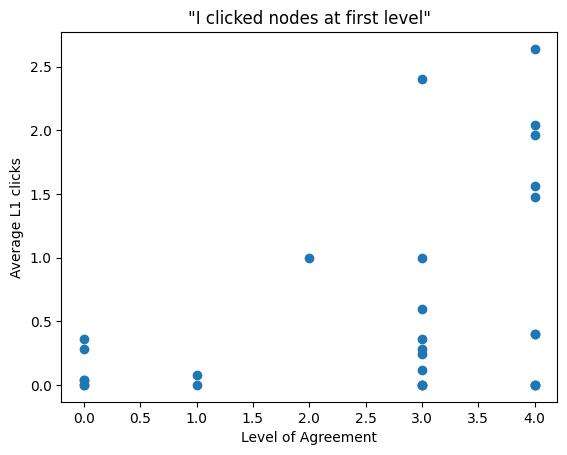

In [149]:
print(strategy_ans_df["Q0"].corr(strategy_ans_df["cL1_mean"]))
plt.scatter(strategy_ans_df["Q0"], strategy_ans_df["cL1_mean"])
plt.title("\"I clicked nodes at first level\"")
plt.xlabel("Level of Agreement")
plt.ylabel("Average L1 clicks")
plt.show()

In [152]:
strategy_ans_df["Q4"].value_counts().sort_index()

Q4
0.0    6
1.0    7
2.0    3
3.0    9
4.0    4
Name: count, dtype: int64

In [156]:
strategy_ans_df.where(strategy_ans_df > 2, 100)

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,3.0,100.0,100.0,100.0,3.0,100.00
1,3.0,100.0,3.0,100.0,3.0,100.00
2,100.0,100.0,3.0,100.0,100.0,100.00
3,4.0,100.0,4.0,4.0,100.0,100.00
4,3.0,100.0,100.0,3.0,100.0,100.00
5,3.0,100.0,100.0,3.0,100.0,100.00
6,100.0,100.0,100.0,100.0,100.0,100.00
8,4.0,100.0,3.0,100.0,3.0,100.00
9,100.0,3.0,100.0,4.0,4.0,100.00
10,100.0,100.0,100.0,3.0,100.0,100.00


In [165]:
agreement_df == 2

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,True,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,True,False
6,False,False,False,False,False,False
8,False,True,False,False,False,False
9,False,False,False,False,False,False
10,False,False,False,False,False,False


In [172]:
agreement_df = strategy_ans_df.copy()
agreement_df = agreement_df.where(agreement_df >= 2, -1)
agreement_df = agreement_df.where(agreement_df <= 2, 1)
agreement_df = agreement_df.where(agreement_df != 2, 0)
agreement_df["cL1_mean"] = strategy_ans_df["cL1_mean"]

agreement_df

,Q0,Q1,Q2,Q3,Q4,cL1_mean
0,1.0,-1.0,-1.0,-1.0,1.0,0.12
1,1.0,-1.0,1.0,-1.0,1.0,0.36
2,-1.0,-1.0,1.0,-1.0,0.0,0.04
3,1.0,-1.0,1.0,1.0,-1.0,1.96
4,1.0,-1.0,-1.0,1.0,-1.0,0.00
5,1.0,-1.0,-1.0,1.0,0.0,0.60
6,-1.0,-1.0,-1.0,-1.0,-1.0,0.00
8,1.0,0.0,1.0,-1.0,1.0,0.00
9,-1.0,1.0,-1.0,1.0,1.0,0.28
10,-1.0,-1.0,-1.0,1.0,-1.0,0.00


In [176]:
(agreement_df["Q1"] + agreement_df["Q2"]).value_counts()

 0.0    13
-2.0    10
-1.0     4
 1.0     2
Name: count, dtype: int64

In [85]:
correct_answers = {
    "Q0": "$-2 to $2",
    "Q1": "$-16 to $16",
    "Q2": "$-88 to $88"
}

num_correct = {}
questions_correct = {}
bonus = {}

for cond in conditions.keys():
    num_correct[cond] = []
    questions_correct[cond] = {
        "Q0": 0,
        "Q1": 0,
        "Q2": 0
    }
    bonus[cond] = []
    sub_df = complete_data.loc[complete_data.condition == cond]
    for idx, row in sub_df.iterrows():
        part = [p for p in part_stats_dicts if p["workerId"] == row["workerId"]][0]
        part_answers = part['final_quiz_responses']
        part_correct_answers = sum([part_answers[key] == correct_answers[key] for key in correct_answers.keys()])
        num_correct[cond].append(part_correct_answers)
        for q in correct_answers.keys():
            questions_correct[cond][q] += int(part_answers[q] == correct_answers[q])
        part_bonus = full_bonus_eligible.loc[full_bonus_eligible.workerId == row["workerId"]].bonus.values[0]
        bonus[cond].append(part_bonus)



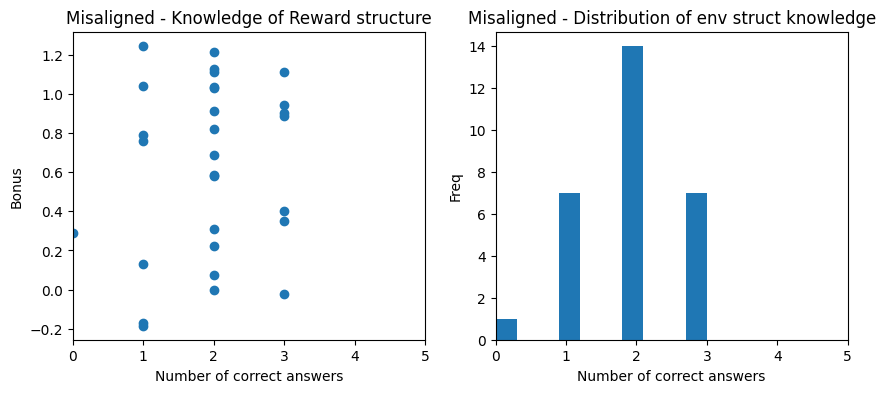

In [86]:


for idx, (cond, condname) in enumerate(conditions.items()):
    plt.figure(figsize=(5 * 2,4 * len(conditions)))
    plt.subplot(1,2,1)
    plt.scatter(num_correct[cond], bonus[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Bonus")
    plt.title(f"{condname} - Knowledge of Reward structure")
    plt.xlim([0,5])
    plt.subplot(1,2,2)
    plt.hist(num_correct[cond])
    plt.xlabel("Number of correct answers")
    plt.ylabel("Freq")
    plt.xlim([0,5])
    plt.title(f"{condname} - Distribution of env struct knowledge")

plt.show()

In [87]:
questions_correct

{0: {'Q0': 20, 'Q1': 13, 'Q2': 23}}